## Model

In [1]:
name = 'ResNN_004'
batch_size = 64
model_basename = 'ResNN4-SDSS'
train_steps = 50000
import sys; sys.argv=['', 
                      '--log_dir', '/nfs/P100/SDSSV_Classifiers/log/%s'%name, 
                      '--model_dir', '/nfs/P100/SDSSV_Classifiers/model/%s'%name, 
                      '--batch_size', '%d'%batch_size,
                      '--model_basename', model_basename,
                      '--train_steps', '%d'%train_steps,
                      '--learning_rate', '1e-3',
                      '--Is_BN', 'True',
                      '--weight_decay','5e-6',
                     ];
del sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow as tf
import numpy as np
import tqdm
tf.logging.set_verbosity(tf.logging.INFO)

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tftool.main import Main

In [4]:
class RunWapper(Main):
    def __init__(self, *args, **kwargs):
        super(RunWapper, self).__init__(*args, **kwargs)
        self.data_shape = 3000
    def __call__(self):
        """an example for constructing network model"""
        self.train_filenames = ["/nfs/P100/SDSSV_Classifiers/processed_dataset/TF_dataset/training.tfrecords"]
        self.valid_filenames = ["/nfs/P100/SDSSV_Classifiers/processed_dataset/TF_dataset/valid.tfrecords"]
        self.Is_training = tf.placeholder(tf.bool,shape=[],name='is_train')
        x, y_ = self.loaddata(repeat=10,shuffle=True)
        net = self.inference(x, is_training=self.Is_training)
        loss = self.Loss_fn(self, net=net, y_=y_)
        train_op = self.optimizer(loss, gclip=1.0)
        self.train(loss, train_op)  
    
    def eval(self, flux, label):
        BS = self.FLAGS.batch_size
        label = label.astype(np.int32)
        print flux.dtype, flux.shape
        print label.dtype, label.shape
        if label.shape[0]%BS == 0:
            loop_num = label.shape[0]//BS
        else:
            loop_num = label.shape[0]//BS + 1
        print "loop number: %d"%loop_num
        #------------------------------------------------------------
        x = tf.placeholder(tf.float32, shape=[None, self.data_shape])
        y_ = tf.placeholder(tf.int32, shape=[None])
        net = self.inference(x, is_training=False)
        loss = self.Loss_fn(self, net=net, y_=y_)
        prob = tf.get_collection('prob')[0]
        LOSS = []
        PROB = []
        with tf.Session(config=self.config) as sess:
            self.Saver = tf.train.Saver(max_to_keep=1)
            self.init_model(sess)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            for i in tqdm.tqdm(xrange(loop_num)):
                el, ep, = sess.run([loss, prob], 
                                   feed_dict={x:flux[i*BS:(i+1)*BS],
                                              y_:label[i*BS:(i+1)*BS]})
                LOSS.append(el)
                PROB.append(ep)
            coord.request_stop()
            coord.join(threads)
        LOSS = np.array(LOSS)
        PROB = np.vstack(PROB)
        return LOSS, PROB
dsc = RunWapper()
print dsc.FLAGS

INFO:tensorflow:(<class 'tftool.main.Main'>, <class 'tftool.Train.Train'>, <class 'tftool.Network.Model'>, <class 'tftool.InputPipeline.InputPipeline'>, <class 'tftool.Utils.Toolkit'>, <class 'tftool.Base.Base'>, <type 'object'>)
Namespace(Is_BN=True, batch_size=64, learning_rate=0.001, log_dir='/nfs/P100/SDSSV_Classifiers/log/ResNN_004', model_basename='ResNN4-SDSS', model_dir='/nfs/P100/SDSSV_Classifiers/model/ResNN_004', train_steps=50000, weight_decay=5e-06)


In [5]:
config = tf.ConfigProto(allow_soft_placement=True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
config.gpu_options.allow_growth = True
dsc.opt = tf.train.AdamOptimizer
#dsc.opt = tf.train.GradientDescentOptimizer
dsc.Is_summary = True
dsc.update_log_step =100
dsc.save_per_steps = 2000
dsc.print_log = False 
dsc.valid_size = 1024
dsc.config = config

### training

In [6]:
dsc()

INFO:tensorflow:Tensor("InputPipeline/input_fn/IteratorGetNext:0", shape=(?, 3000), dtype=float32)
INFO:tensorflow:==========ResNet_softmax==========
INFO:tensorflow:Init variable


 12%|█▏        | 6000/50000 [01:57<14:16, 51.38it/s]

epoch 1: 0.163504


 25%|██▌       | 12500/50000 [04:03<12:05, 51.67it/s]

epoch 2: 0.137878


 37%|███▋      | 18500/50000 [06:00<10:08, 51.78it/s]

epoch 3: 0.128304


 50%|█████     | 25000/50000 [08:05<08:03, 51.70it/s]

epoch 4: 0.120724


 62%|██████▏   | 31000/50000 [10:02<06:07, 51.77it/s]

epoch 5: 0.093635


 75%|███████▌  | 37500/50000 [12:08<04:01, 51.68it/s]

epoch 6: 0.110905


 87%|████████▋ | 43500/50000 [14:05<02:05, 51.63it/s]

epoch 7: 0.132687


100%|██████████| 50000/50000 [16:12<00:00, 51.41it/s]


---
## Evaluation

In [6]:
data_test = np.load('/nfs/P100/SDSSV_Classifiers/processed_dataset/TF_dataset/test.npy')
#data_test = np.load('/nfs/P100/SDSSV_Classifiers/processed_dataset/TF_dataset/valid.npy')

In [7]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint')) as f:
    mid = f.readline().split('/')
    mid = mid[-2]+'_'+mid[-1][:-2]

In [8]:
loss, prob = dsc.eval(data_test['flux_norm'], data_test['label'])

float32 (1778, 3000)
int32 (1778,)
loop number: 28
INFO:tensorflow:Tensor("Placeholder:0", shape=(?, 3000), dtype=float32)
INFO:tensorflow:==========ResNet_softmax==========
INFO:tensorflow:load variable from /nfs/P100/SDSSV_Classifiers/model/ResNN_004/ResNN4-SDSS-49999
INFO:tensorflow:Restoring parameters from /nfs/P100/SDSSV_Classifiers/model/ResNN_004/ResNN4-SDSS-49999


100%|██████████| 28/28 [00:01<00:00, 27.30it/s]


### check result

In [24]:
import matplotlib.pyplot as plt
params = {
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'figure.figsize': [6, 6],
    #----------
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'image.cmap': 'jet',
    #'image.cmap': 'Greys',
    'legend.frameon':  False,
    'xtick.top': True,
    'ytick.right': True,
    #----------
    'lines.linewidth': 2.0,
#    'axes.labelsize': 12,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.top': True, 
    'xtick.minor.bottom': True, 
    'ytick.minor.left': True, 
    'ytick.minor.right': True,
   }
plt.rcParams.update(params)

In [25]:
name_type = {0:'wdsb2', 1:'wd', 2:'yso', 3:'hotstars', 4:'fgkm', 5:'cv'}

In [26]:
p_label = np.argmax(prob,axis=1)

In [27]:
print p_label[:30]
print data_test['label'][:30]

[4 1 3 4 4 4 4 1 0 3 4 3 3 4 3 4 4 1 1 1 4 1 1 4 4 3 4 3 4 4]
[4 1 1 4 4 4 4 1 0 1 4 1 3 4 1 4 4 1 1 1 4 1 1 4 4 1 4 1 4 4]


In [28]:
m = np.c_[data_test['label'],p_label]
matrix = np.zeros([6,6],dtype=np.float32)
for i,j in m:
    matrix[i,j]+=1.

__main__:3: RuntimeWarning: divide by zero encountered in log10


['wdsb2\n20', 'wd\n784', 'yso\n33', 'hotstars\n86', 'fgkm\n842', 'cv\n13']
['wdsb2\n20', 'wd\n714', 'yso\n33', 'hotstars\n157', 'fgkm\n841', 'cv\n13']


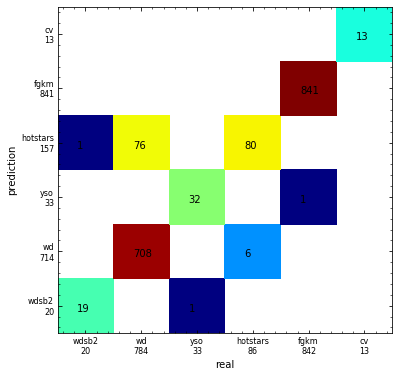

In [31]:

plt.rcParams.update(params)
plt.pcolor(np.log10(matrix.T))
#plt.colorbar()
for i in xrange(6):
    for j in xrange(6):
        if matrix[i,j]!=0:
            plt.text(i+0.35,j+0.4,"%d"%np.round(matrix[i,j]),color='k')
plt.xlabel('real')
plt.ylabel('prediction')
ticks_real = [name_type[key]+'\n%d'%(np.sum(data_test['label']==key)) for key in name_type.keys()]
ticks_pred = [name_type[key]+'\n%d'%(np.sum(p_label==key)) for key in name_type.keys()]
print ticks_real
print ticks_pred
plt.xticks(np.array(name_type.keys())+0.5,ticks_real)
plt.yticks(np.array(name_type.keys())+0.5,ticks_pred)
plt.savefig('result/pred_matrix.pdf')